# Minimal example with TensorFlow 2.0
In this notebook we will recreate our machine learning algorithm using TF 2.0.

### Import relevant libraries

In [2]:
# We must always import the relevant libraries for our problem at hand. 
# NumPy and TensorFlow are required for this example.
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Data generation

We generate data using the exact same logic and code as the Numpy example. The only difference now is that we save it to an npz file. Npz is numpy's file type which allows you to save numpy arrays into a single .npz file. We introduce this change because in machine learning most often: 

* you are given some data (csv, database, etc.)
* you preprocess it into a desired format (later on we will see methods for preprocesing)
* you save it into npz files (if you're working in Python) to access later

In [3]:
# First, we should declare a variable containing the size of the training set we want to generate.
observations = 1000

# We will work with two variables as inputs. You can think about them as x1 and x2 in our previous examples.
# We have picked x and z, since it is easier to differentiate them.
# We generate them randomly, drawing from an uniform distribution. There are 3 arguments of this method (low, high, size).
# The size of xs and zs is observations x 1. In this case: 1000 x 1.
xs = np.random.uniform(low=-10, high=10, size=(observations,1))
zs = np.random.uniform(-10, 10, (observations,1))

# Combine the two dimensions of the input into one input matrix. 
# This is the X matrix from the linear model y = x*w + b.
# column_stack is a Numpy method, which combines two matrices (vectors) into one.
generated_inputs = np.column_stack((xs,zs))

# We add a random small noise to the function i.e. f(x,z) = 2x - 3z + 5 + <small noise>
noise = np.random.uniform(-1, 1, (observations,1))

# Produce the targets according to our f(x,z) = 2x - 3z + 5 + noise definition.
# In this way, we are basically saying: the weights should be 2 and -3, while the bias is 5.
generated_targets = 2*xs - 3*zs + 5 + noise

# save into an npz file called "TF_intro"
np.savez('Data/TF_intro', inputs=generated_inputs, targets=generated_targets)

## Solving with TensorFlow

<i/>Note: This intro is just the basics of TensorFlow which has way more capabilities and depth than that.<i>

In [4]:
# Load the training data from the NPZ
training_data = np.load('Data/TF_intro.npz')

In [5]:
# Declare a variable where we will store the input size of our model
# It should be equal to the number of variables you have
input_size = 2
# Declare the output size of the model
# It should be equal to the number of outputs you've got (for regressions that's usually 1)
output_size = 1

# Outline the model
# We lay out the model in 'Sequential'
# Note that there are no calculations involved - we are just describing our network
model = tf.keras.Sequential([
                            # Each 'layer' is listed here
                            # The method 'Dense' indicates, our mathematical operation to be (xw + b)
                            tf.keras.layers.Dense(output_size,
                                                 # there are extra arguments you can include to customize your model
                                                 # in our case we are just trying to create a solution that is 
                                                 # as close as possible to our NumPy model
                                                 kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1),
                                                 bias_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1)
                                                 )
                            ])

# We can also define a custom optimizer, where we can specify the learning rate
custom_optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
# Note that sometimes you may also need a custom loss function 
# That's much harder to implement and won't be covered in this course though

# 'compile' is the place where you select and indicate the optimizers and the loss
model.compile(optimizer=custom_optimizer, loss='mean_squared_error')

# finally we fit the model, indicating the inputs and targets
# if they are not otherwise specified the number of epochs will be 1 (a single epoch of training), 
# so the number of epochs is 'kind of' mandatory, too
# we can play around with verbose; we prefer verbose=2
model.fit(training_data['inputs'], training_data['targets'], epochs=100, verbose=2)

Epoch 1/100
32/32 - 1s - 31ms/step - loss: 20.8335
Epoch 2/100
32/32 - 0s - 4ms/step - loss: 1.1325
Epoch 3/100
32/32 - 0s - 3ms/step - loss: 0.4385
Epoch 4/100
32/32 - 0s - 4ms/step - loss: 0.3681
Epoch 5/100
32/32 - 0s - 4ms/step - loss: 0.4035
Epoch 6/100
32/32 - 0s - 3ms/step - loss: 0.3981
Epoch 7/100
32/32 - 0s - 3ms/step - loss: 0.3946
Epoch 8/100
32/32 - 0s - 3ms/step - loss: 0.3903
Epoch 9/100
32/32 - 0s - 5ms/step - loss: 0.3878
Epoch 10/100
32/32 - 0s - 3ms/step - loss: 0.3938
Epoch 11/100
32/32 - 0s - 3ms/step - loss: 0.3637
Epoch 12/100
32/32 - 0s - 5ms/step - loss: 0.3665
Epoch 13/100
32/32 - 0s - 3ms/step - loss: 0.3928
Epoch 14/100
32/32 - 0s - 5ms/step - loss: 0.3441
Epoch 15/100
32/32 - 0s - 6ms/step - loss: 0.3698
Epoch 16/100
32/32 - 0s - 3ms/step - loss: 0.3813
Epoch 17/100
32/32 - 0s - 6ms/step - loss: 0.3738
Epoch 18/100
32/32 - 0s - 6ms/step - loss: 0.3622
Epoch 19/100
32/32 - 0s - 3ms/step - loss: 0.3669
Epoch 20/100
32/32 - 0s - 3ms/step - loss: 0.3594
Epoch 2

## Extract the weights and bias
Extracting the weight(s) and bias(es) of a model is not an essential step for the machine learning process. In fact, usually they would not tell us much in a deep learning context. However, this simple example was set up in a way, which allows us to verify if the answers we get are correct.

In [6]:
# Extracting the weights and biases is achieved quite easily
model.layers[0].get_weights()

[array([[ 1.9433231],
        [-2.9666812]], dtype=float32),
 array([5.0094824], dtype=float32)]

In [7]:
# We can save the weights and biases in separate variables for easier examination
# Note that there can be hundreds or thousands of them!
weights = model.layers[0].get_weights()[0]
weights

array([[ 1.9433231],
       [-2.9666812]], dtype=float32)

In [8]:
# We can save the weights and biases in separate variables for easier examination
# Note that there can be hundreds or thousands of them!
bias = model.layers[0].get_weights()[1]
bias

array([5.0094824], dtype=float32)

## Extract the outputs (make predictions)
Once more, this is not an essential step, however, we usually want to be able to make predictions.

In [9]:
# We can predict new values in order to actually make use of the model
# Sometimes it is useful to round the values to be able to read the output
# Usually we use this method on NEW DATA, rather than our original training data
model.predict_on_batch(training_data['inputs']).round(1)

array([[ 14.4],
       [  5.6],
       [ 10.3],
       [ -1.9],
       [  3.9],
       [-43.1],
       [ 27.9],
       [-30.3],
       [ 17.6],
       [ 12.8],
       [-20.1],
       [  1.9],
       [  7.3],
       [  5.3],
       [-31. ],
       [ -0.4],
       [ 16.2],
       [ 20.2],
       [  2.5],
       [ 17.7],
       [-26.5],
       [ 22.2],
       [-21.2],
       [ 36.6],
       [ -5.3],
       [-28.4],
       [ 39.3],
       [-10.7],
       [ 45.6],
       [ 16.1],
       [ 47.6],
       [ 46.8],
       [  1.2],
       [ 23.4],
       [ 20.3],
       [  9.1],
       [  0.9],
       [ -3.5],
       [  0.6],
       [ 10.7],
       [ 34.5],
       [ 30.6],
       [  4.4],
       [ -3.5],
       [-22.1],
       [ -4.4],
       [ -6.3],
       [  8.5],
       [ 14.9],
       [-14.3],
       [ 26.8],
       [  6.2],
       [  6.7],
       [-18.8],
       [  6.1],
       [ 52.8],
       [  0.7],
       [  0.7],
       [ 38.8],
       [-18.7],
       [ 18.3],
       [ -1.9],
       [

In [10]:
# If we display our targets (actual observed values), we can manually compare the outputs and the targets
training_data['targets'].round(1)

array([[ 15.1],
       [  5.9],
       [  9.9],
       [ -1.8],
       [  3.3],
       [-43.4],
       [ 29.1],
       [-30.6],
       [ 18.1],
       [ 13.5],
       [-21.5],
       [  2.2],
       [  8.2],
       [  4.6],
       [-32. ],
       [ -1.4],
       [ 17. ],
       [ 21.2],
       [  2.8],
       [ 17.6],
       [-27.2],
       [ 23. ],
       [-22.1],
       [ 37. ],
       [ -6. ],
       [-29.7],
       [ 39.1],
       [-11.6],
       [ 46.2],
       [ 15.8],
       [ 49. ],
       [ 47.6],
       [  1.6],
       [ 24.2],
       [ 20.1],
       [ 10.3],
       [  1.6],
       [ -2.6],
       [  0.2],
       [ 11.6],
       [ 34.3],
       [ 31.2],
       [  4.7],
       [ -3.5],
       [-22.7],
       [ -5.4],
       [ -6.5],
       [  9.1],
       [ 15.1],
       [-14.5],
       [ 27.3],
       [  5.7],
       [  5.9],
       [-19.9],
       [  6.4],
       [ 54.5],
       [  0.1],
       [  1.5],
       [ 39.4],
       [-18.7],
       [ 18.2],
       [ -3.2],
       [

## Plotting the data

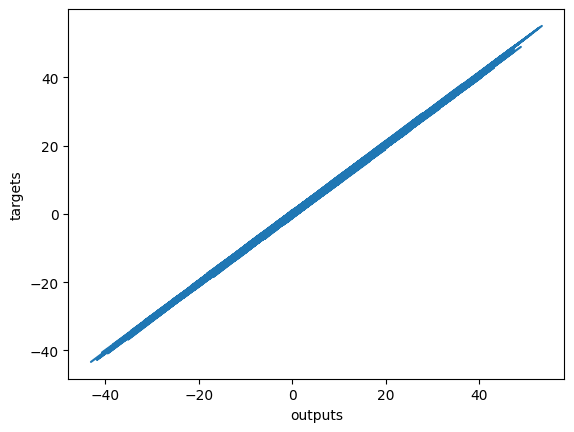

In [11]:
# The model is optimized, so the outputs are calculated based on the last form of the model

# We have to np.squeeze the arrays in order to fit them to what the plot function expects.
# Doesn't change anything as we cut dimensions of size 1 - just a technicality.
plt.plot(np.squeeze(model.predict_on_batch(training_data['inputs'])), np.squeeze(training_data['targets']))
plt.xlabel('outputs')
plt.ylabel('targets')
plt.show()

# Voila - what you see should be exactly the same as in the previous notebook!
# You probably don't see the point of TensorFlow now - it took us the same number of lines of code
# to achieve this simple result. However, once we go deeper in the next chapter,
# TensorFlow will save us hundreds of lines of code.

In [13]:
deltas = model.predict_on_batch(training_data['inputs']) - generated_targets

deltas_perc = abs(deltas / generated_targets)

accuracy = 1 - np.average(deltas_perc, weights = generated_targets)

print('Test accuracy: {:.2f}%'.format(accuracy*100.))

Test accuracy: 98.27%
